In [53]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from torch.utils.data import Dataset

ds = load_dataset("nlphuji/flickr30k")

print(ds)

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})


In [11]:
from collections import Counter
print(Counter(ds['test']['split']))

Counter({'train': 29000, 'val': 1014, 'test': 1000})


In [ ]:
from torchvision import transforms

class Flickr30k(Dataset):
    def __init__(self, split, image_transforms = None):
        super().__init__()

        self.ds = load_dataset("nlphuji/flickr30k")
        if split not in ['test', 'train', 'val']:
            raise ValueError("fsplit {split} must be in ['test', 'train', 'val'] ")
        self.split = split
        self.split_idxs = self._make_split_idxs(split)

        # Image transforms
        self.image_transforms = transforms.Compose([transforms.PILToTensor()])
    
    def __getitem__(self, index):
        # Returns first caption, there's typically 5 captions
        return self.image_transforms(self.ds['test'][index]['image']), self.ds['test'][index]['caption'][0]
    
    def __len__(self):
        return len(self.split_idxs)
    
    def _make_split_idxs(self, split):
        split_idxs = []
        for idx, s in enumerate(self.ds['test']['split']):
            if s == split:
                split_idxs.append(idx)
        return split_idxs
    
    def __repr__(self):
        return str(f"Flickr30k {self.split} split\nNum_instances: {self.__len__()}" )
    
ds = Flickr30k('val')

TypeError: Flickr30k.__init__() missing 1 required positional argument: 'image_transforms'

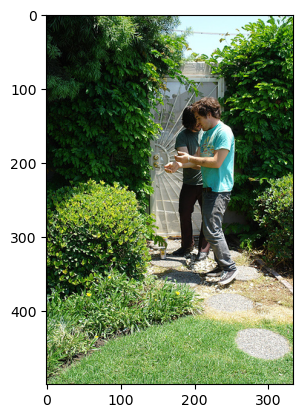

In [ ]:
import torch
transform = transforms.Compose([transforms.PILToTensor()])

import matplotlib.pyplot as plt

plt.imshow(transform(ds[0][0]).permute(1,2,0))

In [63]:
type(ds[0][0])

PIL.JpegImagePlugin.JpegImageFile